# Exercise: Application of Machine Learning in Real Estate Price Prediction

## Objective:
Understand and apply machine learning techniques to predict housing prices using the Kaggle dataset.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import MinMaxScaler  
import pickle
import os
import warnings
from scipy.stats import norm
from scipy import stats
from boruta import BorutaPy

%matplotlib inline
%load_ext autoreload

In [2]:
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [3]:
# Set the option to display all rows
pd.set_option('display.max_rows', None)

# Set the option to display all columns
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv(r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\train.csv')
df_test = pd.read_csv(r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\test.csv')

df_orig = df.copy()
df_test_orig = df_test.copy()

### Functions and Classes Used:

In [5]:
scores = dict()

def divide_features(df):
    """A function to divide the data into numerical and categorical features.

    Args:
        df (DataFrame): The dataframe to divide into numerical and categorical features.

    Returns:
        numerical_features: All the numerical features in the dataframe.
        categorical_features: All the categorical features in the dataframe.
    """
    numerical_cols = df.select_dtypes(include=[np.number])
    categorical_cols = df.select_dtypes(include=[object])
    return numerical_cols.columns, categorical_cols.columns


def display_numerical_features(df, feature_names, target):
    """A function to display a subplots of the numerical features.

    Args:
        df (DataFrame): The dataframe to display the subplots of the numerical features.
        feature_names (list | index): The list of numerical features to display.
        target (Series): The target variable.
    """
    for feature in feature_names:
        fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
        sns.distplot(df[feature], fit=norm, ax=axs[0], bins=100)
        sns.scatterplot(x=feature, y=target, data=df, ax=axs[1])
        plt.show()


def display_categorical_features(df, features_names, target):
    """A function to display a subplots of the categorical features. 
    The first subplot is a count plot of the feature and the second subplot is a box plot of the feature vs the target variable.

    Args:
        df (DataFrame): The dataframe to display the subplots of the categorical features.
        features (list | index): The list of categorical features to display.
        target (Series): The target variable.
    """
    for feature in features_names:
        fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
        sns.countplot(x=feature, data=df, ax=axs[0])
        sns.boxplot(x=feature, y=target, data=df, ax=axs[1])
        plt.show()


def display_missing_values(df):
    """A function to find the missing values for each feature 
    and display them in a dataframe along with the percentage of missing values for each feature.

    Args:
        df (DataFrame): The dataframe to display the missing values.

    Returns:
        DataFrame: A dataframe containing the missing values and the percentage of missing values for each feature.
    """
    missing_values = df.isnull().sum().sort_values(ascending=False)
    missing_values = missing_values[missing_values > 0]
    missing_values = pd.DataFrame(missing_values, columns=['Missing Values'])
    missing_values['Percentage'] = missing_values['Missing Values'] / df.shape[0]
    return missing_values


def build_pipeline(numerical_columns, categorical_columns):
    """A function to build a pipeline that contains a preprocessor to impute missing values for numerical features with the median value of each feature,
    impute missing values for categorical features with most frequent values, and one hot encode categorical features, and a RandomForestRegressor model.

    Args:
        numerical_columns (_type_): _description_
        categorical_columns (_type_): _description_

    Returns:
        Pipeline: A pipeline that contains a preprocessor, and a RandomForestRegressor model.
    """
    
    # Preprocessor for numerical data
    numerical_transformer = SimpleImputer(strategy='median')

    # Preprocessor for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ])

    # Define model
    model = RandomForestRegressor(random_state=42, n_jobs=-1)

    # Bundle preprocessing and modeling code in a pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', model)
                            ])
    return pipeline


# Impute missing values of categorical features based on the markdown above
def impute_no_feature(df, feature_list):
    """A function to impute missing values of categorical features whose missing values represent a lack of the feature.

    Args:
        df (DataFrame): The dataframe to impute the missing values of categorical features.
        feature_list (list): The list of categorical features to impute their missing values.
    """
    for feature in feature_list:
        df[feature] = df[feature].fillna(f'No {feature}')

def log_rmse(y_true, y_pred):
    """Calculate the RMSE with logarithmic transformation."""
    return np.sqrt(mean_squared_error(np.log(y_true), np.log(y_pred)))

def cross_validate_estimator(estimator, X, y, cv):
    """Cross-validate an estimator with RMSE between log of predictions and log of actual values.

    Args:
        estimator (model): The estimator to use for cross-validation.
        X (DataFrame): Features for cross-validation.
        y (Series): Target variable for cross-validation.
        cv (int): Number of folds for cross-validation.

    Returns:
        dict: Dictionary with average and std of cross-validation scores.
    """
    # Default cross-validation
    cv_scores = cross_val_score(estimator, X, y, cv=cv, n_jobs=-1)
    print(f"Cross-validation scores: {cv_scores}, scores average: {cv_scores.mean()}, std: {cv_scores.std()}")

    # Custom RMSE cross-validation
    log_rmse_scorer = make_scorer(log_rmse, greater_is_better=False)
    cv_scores_log_rmse = -cross_val_score(estimator, X, y, cv=cv, scoring=log_rmse_scorer, n_jobs=-1)
    print(f"Log RMSE Cross-validation scores: {cv_scores_log_rmse}, scores average: {cv_scores_log_rmse.mean()}, std: {cv_scores_log_rmse.std()}")

    return {
        'average_cv_score': cv_scores.mean(),
        'std_cv_score': cv_scores.std(),
        'average_cv_score_log_rmse': cv_scores_log_rmse.mean(),
        'std_cv_score_log_rmse': cv_scores_log_rmse.std()
    }


def convert_to_categorical(df, columns, num_features, cat_features):
    """A function to convert numerical features to categorical features.

    Args:
        df (DataFrame): The dataframe to convert the numerical features to categorical features.
        columns (list): The list of numerical features to convert to categorical features.
        num_features (Index): The list of numerical features.
        cat_features (Index): The list of categorical features.

    Returns:
        num_features (Index): The updated list of numerical features.
        cat_features (Index): The updated list of categorical features.
    """
    # Convert Index objects to lists for modification
    num_features_list = num_features.tolist()
    cat_features_list = cat_features.tolist()

    for col in columns:
        if col in num_features_list:
            # Convert the column to categorical in the DataFrame
            df[col] = df[col].astype('object')

            # Update lists
            num_features_list.remove(col)
            cat_features_list.append(col)

    # Convert lists back to Index objects
    return pd.Index(num_features_list), pd.Index(cat_features_list)


def convert_to_numerical(df, columns, num_features, cat_features):
    """A function to convert categorical features to numerical features.

    Args:
        df (DataFrame): The dataframe to convert categorical features to numerical features.
        columns (list): The list of categorical features to convert to numerical features.
        num_features (Index): The list of numerical features.
        cat_features (Index): The list of categorical features.

    Returns:
        num_features (Index): The updated list of numerical features.
        cat_features (Index): The updated list of categorical features.
    """
    # Convert Index objects to lists for modification
    num_features_list = num_features.tolist()
    cat_features_list = cat_features.tolist()

    for col in columns:
        if col in cat_features_list:
            # Convert the column to numerical in the DataFrame (assuming it can be converted directly)
            df[col] = pd.to_numeric(df[col], errors='coerce')

            # Update lists
            cat_features_list.remove(col)
            num_features_list.append(col)

    # Convert lists back to Index objects
    return pd.Index(num_features_list), pd.Index(cat_features_list)


def pickle_object(var):
    """A function to pickle an object. You must specify the directory path and the file name.

    Args:
        var (some variable): The variable to pickle.
    """
    # Specify the directory path
    directory = input("Path to directory: ")  # Replace with your desired path
    file_name = input("File name: ")  # Replace with your desired file name

    # Ensure the directory exists, create if it doesn't
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Specify the file path
    file_path = os.path.join(directory, file_name)

    # Save the object to the specified directory
    with open(file_path, 'wb') as file:
        pickle.dump(var, file)


def outlier_removal(data, column):
    """A function to remove outliers from a specified column in a dataframe.

    Args:
        data (DataFrame): The dataframe to remove outliers from.
        column (Series): The column to remove outliers from.
    """
    # Calculate Q1, Q3, and IQR for the specified column
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Adjust outliers
    data.loc[data[column] < lower_bound, column] = lower_bound
    data.loc[data[column] > upper_bound, column] = upper_bound


def model_prediction(model, X_test, original_data):
    """A function to make predictions using a model and save the predictions to a csv file along with the Id column.

    Args:
        model (estimator): The model to make predictions with.
        X_test (DataFrame): The test data to make predictions on.
        original_data (DataFrame): The original data to get the Id column from.
    """
    # PModel predictions
    predictions = model.predict(X_test)

    # Prepare submission file
    submission = pd.DataFrame({
        'Id': original_data['Id'],
        'SalePrice': predictions
    })

    # Get file name from user
    file_name = input('File Name: ')

    # Save submission file as csv
    submission.to_csv(f'{file_name}.csv', index=False)


def display_feature_importance(pipeline, categorical_features, numerical_features, n=None):
    """
    A function to display the feature importance of the top n features.

    Args:
        pipeline (Pipeline): The pipeline to display the feature importance from.
        categorical_features (list): List of categorical feature names.
        numerical_features (list): List of numerical feature names.
        n (int, optional): The number of features to display. Defaults to the total number of features.
    """
    # Access the model
    rf_model = pipeline.named_steps['model']

    # Get feature importances
    importances = rf_model.feature_importances_

    # Get feature names after preprocessing
    preprocessor = pipeline.named_steps['preprocessor']
    cat_transformer = preprocessor.named_transformers_['cat']
    cat_one_hot_features = cat_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names = list(numerical_features) + list(cat_one_hot_features)

    # Calculate total features if n is not specified
    if n is None:
        n = len(feature_names)

    # Create a DataFrame of feature importances
    feature_importances = pd.DataFrame(importances, index=feature_names, columns=['importance'])

    # Sort the DataFrame in descending order of feature importance
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)

    # Plot the feature importances of n most important features in horizontal bar chart
    plt.figure(figsize=(10, 8))
    plt.title(f'Top {n} most important features')
    sns.barplot(x=feature_importances['importance'][:n], y=feature_importances.index[:n])
    plt.show()


def remove_feature(train_data, test_data, feature, feature_index):
    """A function to remove a feature from the training and test data.

    Args:
        train_data (DataFrame): The training data to remove the feature from.
        test_data (DataFrame): The test data to remove the feature from.
        feature (str): The name of the feature to remove.
        feature_index (index): The index of the feature to remove.
    """
    features_list = feature_index.tolist()
    features_list.remove(feature)
    feature_index = pd.Index(features_list)
    train_data = train_data.drop(feature, axis=1)
    test_data = test_data.drop(feature, axis=1)
    
    return train_data, test_data, feature_index


def pipeline_rebuilder(X, y, numerical_features, categorical_features, title):
    """A function to rebuild the pipeline after removing or changing features.

    Args:
        X (DataFrame): The features to use for cross-validation.
        y (Series): The target variable to use for cross-validation.
        numerical_features (Index): The list of numerical features.
        categorical_features (Index): The list of categorical features.

    Returns:
        Pipeline: A pipeline that contains a preprocessor, and a RandomForestRegressor model.
    """
    # Build the data pipeline
    rf_pipeline = build_pipeline(numerical_columns=numerical_features, categorical_columns=categorical_features)

    # Fit the pipeline
    rf_pipeline.fit(X, y)
    
    # Print title
    print(title)
    
    # Cross validation
    current_scores = cross_validate_estimator(estimator=rf_pipeline, X=X, y=y, cv=5)

    display_feature_importance(
        pipeline=rf_pipeline, 
        categorical_features=categorical_features, 
        numerical_features=numerical_features, n=30
        )
    
    # Save the cross validation scores to the scores dictionary
    scores[title] = current_scores

    return rf_pipeline

def extract_processed_df(pipeline, X, numerical_features, categorical_features):
    """A function to extract the processed dataframe from the pipeline.

    Args:
        pipeline (Pipeline): The pipeline to extract the processed dataframe from.
        X (DataFrame): The features to use for cross-validation.

    Returns:
        DataFrame: The processed dataframe.
    """
    # Extract the preprocessor
    preprocessor = pipeline.named_steps['preprocessor']

    # Extract the column names after preprocessing
    cat_transformer = preprocessor.named_transformers_['cat']
    cat_one_hot_features = cat_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names = list(numerical_features) + list(cat_one_hot_features)

    # Extract the processed dataframe
    processed_df = pd.DataFrame(preprocessor.transform(X), columns=feature_names)

    return processed_df

## Preparation

### Short EDAs

In [6]:
# create a target variable
y = df['SalePrice']

# Get the numerical and categorical features without the target variable and Id
numerical_features, categorical_features = divide_features(df.drop(['SalePrice', 'Id'], axis=1))

# Create a list of all features
all_features = list(numerical_features) + list(categorical_features)

Skewness: 1.882876
Kurtosis: 6.536282


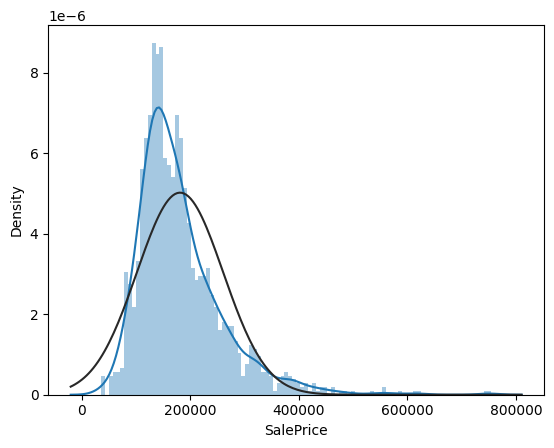

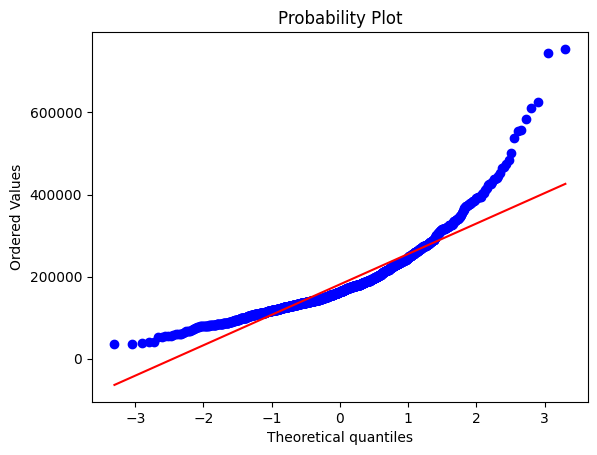

In [7]:
# Describe the target variable
y.describe()

# Plot the distribution of the target variable and show the skewness and kurtosis as well as compare it to a normal distribution
sns.distplot(y, fit=norm, bins=100, kde=True);
fig = plt.figure()
res = stats.probplot(y, plot=plt)

# Skewness and kurtosis
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

In [8]:
# display_numerical_features(df=df, feature_names=numerical_features, target=y)

- There are features that should be categorical but are numerical. We will convert them to categorical features:
    - MSSubClass
    - MoSold
    - YrSold
    - OverallQual
    - OverallCond
    - BsmtFullBath
    - BsmtHalfBath
    - FullBath
    - HalfBath
    - BedroomAbvGr
    - KitchenAbvGr
    - TotRmsAbvGrd
    - Fireplaces
    - GarageCars
    - PoolArea
    - MiscVal

In [9]:
# display_categorical_features(df=df, features_names=categorical_features, target=y)

## Part 1: Data Preprocessing and Feature Engineering
- Task: Handle missing values and categorize data in the dataset.
- Use techniques learned in Meeting 15 to deal with missing values and categories.
- Feature Engineering:
    - Implement fixed-width and quantile-based binning strategies from Meeting 16.
    - Document the rationale behind choosing specific bins and the impact on the dataset.


In [10]:
# Display missing values for numerical features in the training data
print("Missing values for numerical features in the training data:")
print(display_missing_values(df[numerical_features]))
print()

# Display missing values for categorical features in the training data
print("Missing values for categorical features in the training data:")
print(display_missing_values(df[categorical_features]))
print()

# Display missing values for numerical features in the test data
print("Missing values for numerical features in the test data:")
display_missing_values(df_test[numerical_features])
print()

# Display missing values for categorical features in the test data
print("Missing values for categorical features in the test data:")
display_missing_values(df_test[categorical_features])
print()

Missing values for numerical features in the training data:
             Missing Values  Percentage
LotFrontage             259       0.177
GarageYrBlt              81       0.055
MasVnrArea                8       0.005

Missing values for categorical features in the training data:
              Missing Values  Percentage
PoolQC                  1453       0.995
MiscFeature             1406       0.963
Alley                   1369       0.938
Fence                   1179       0.808
MasVnrType               872       0.597
FireplaceQu              690       0.473
GarageType                81       0.055
GarageCond                81       0.055
GarageQual                81       0.055
GarageFinish              81       0.055
BsmtFinType2              38       0.026
BsmtExposure              38       0.026
BsmtFinType1              37       0.025
BsmtQual                  37       0.025
BsmtCond                  37       0.025
Electrical                 1       0.001

Missing values for 

- Choose which strategy to use to impute each numerical feature:
    - 'LotFrontage': 'Zero'
    - 'MasVnrArea': 'mean' (will leave to the imputer)
    - 'GarageYrBlt': 'Zero'
- Choose which strategy to use to impute each categorical feature:
    - 'Alley': 'No alley access'
    - 'MasVnrType': 'No veneer'
    - 'BsmtQual': 'No Basement'
    - 'BsmtCond': 'No Basement'
    - 'BsmtExposure': 'No Basement'
    - 'BsmtFinType1': 'None'
    - 'BsmtFinType2': 'None'
    - 'Electrical': 'Most common value' (will leave to the imputer)
    - 'FireplaceQu': 'No Fireplace'
    - 'GarageType': 'No Garage'
    - 'GarageFinish': 'No Garage'
    - 'GarageQual': 'No Garage'
    - 'GarageCond': 'No Garage'
    - 'PoolQC': 'No Pool'
    - 'Fence': 'No Fence'
    - 'MiscFeature': 'None'

*** We do the imputation manually because in many of the features missing values actually mean lack of that feature.

In [11]:
# Impute missing values of numerical features based on the markdown above
df['LotFrontage'] = df['LotFrontage'].fillna(0)

df['YearBuilt'] = df['YearBuilt'].fillna(0)

In [12]:
# Impute missing values of categorical features based on the markdown above

# Find all missing value columns and put their names in a list
cat_features_with_missing = display_missing_values(df[categorical_features]).index.to_list()
cat_features_with_missing.remove('MiscFeature') # Remove 'MiscFeature' in order to impute separately

# Manually impute categorical features
impute_no_feature(df=df, feature_list=cat_features_with_missing)

df['MiscFeature'] = df['MiscFeature'].fillna('None')

## Part 2: Baseline Model Creation and Evaluation
- Baseline Model: Construct a baseline model using the Random Forest algorithm and the features engineered in Part 1.
- Evaluation:
    - Perform k-fold cross-validation.
    - Use default scoring and negative mean squared error metrics.
- Task: Plot and analyze the feature importance graph to understand the impact of each feature.


In [13]:
# Move suspected categorical features from the numerical list to the categorical
suspected_categorical = [
    'MSSubClass',
    'MoSold',
    'YrSold',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageCars',
    'PoolArea',
    'MiscVal',
    'OverallQual',
    'OverallCond'
]

In [14]:
# Build the data pipeline
rf_pipeline_base = build_pipeline(numerical_columns=numerical_features, categorical_columns=categorical_features)

# Remove target from base DataFrame
X = df.drop('SalePrice', axis=1)

# Fit the pipeline
rf_pipeline_base.fit(X, y)

# Cross validation
current_scores = cross_validate_estimator(estimator=rf_pipeline_base, X=X, y=y, cv=5)

scores['Base RF model'] = current_scores

Cross-validation scores: [0.87335265 0.84706038 0.87082506 0.88219099 0.81151918], scores average: 0.8569896534903594, std: 0.025535969266132393
Log RMSE Cross-validation scores: [0.14014647 0.15483247 0.14498248 0.13942453 0.15599688], scores average: 0.14707656765732044, std: 0.007080835895431543


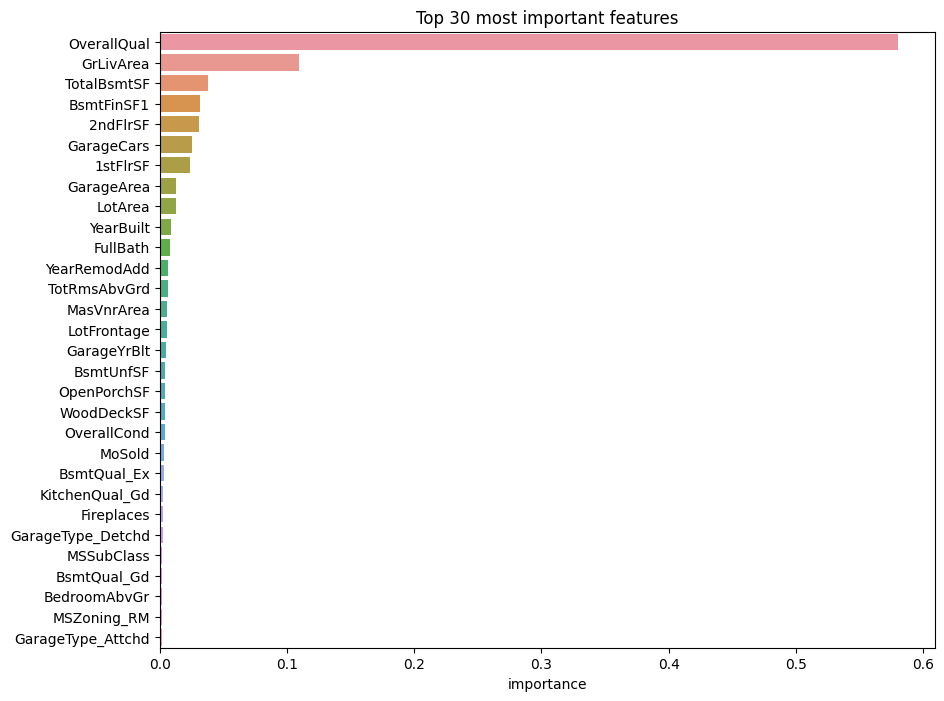

In [15]:
display_feature_importance(
    pipeline=rf_pipeline_base, 
    categorical_features=categorical_features, 
    numerical_features=numerical_features, n=30
    )

## Part 3: Categorical Feature Transformation and Analysis
- Feature Transformation:
    - Convert 'OverallQual' and 'GarageCars' into categorical features.
    - Analyze how this transformation affects feature importance.
- Sale Price Estimation:
    - Calculate the mean SalePrice per GrLivArea.
    - Create a new column estimating the apartment price (GrLivArea * mean SalePrice).
- Prediction and Kaggle Submission:
    - Predict prices on the test dataset using the new features.
    - Submit to Kaggle and document the score received.


OverallQual and GarageCars converted to categorical
Cross-validation scores: [0.88692382 0.78782564 0.8656359  0.87480888 0.85531991], scores average: 0.8541028281906271, std: 0.034736481496690126
Log RMSE Cross-validation scores: [0.13580322 0.16637417 0.15196841 0.15084781 0.14449127], scores average: 0.14989697699855126, std: 0.010045381129145095


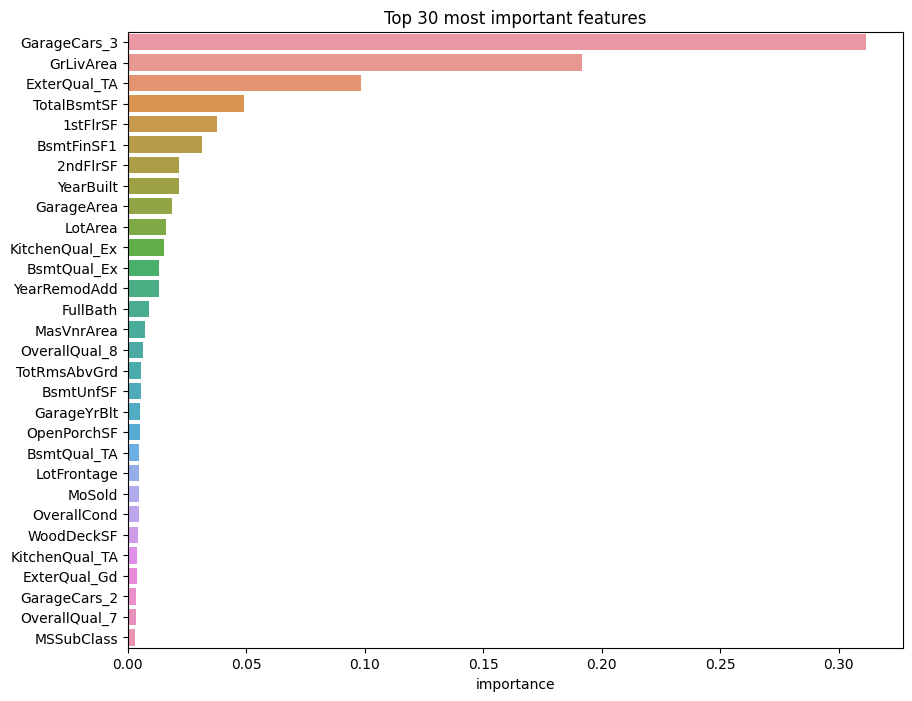

In [16]:
# Convert 'OverallQual' and 'GarageCars' to categorical features
numerical_features_1, categorical_features_1 = convert_to_categorical(
    df=X,
    columns=['OverallQual', 'GarageCars'],
    num_features=numerical_features,
    cat_features=categorical_features
)

# Rebuild the pipeline
title = "OverallQual and GarageCars converted to categorical"
rf_pipeline_v1 = pipeline_rebuilder(X=X, y=y, numerical_features=numerical_features_1, categorical_features=categorical_features_1, title=title)

In [19]:
# Calculate the mean SalePrice per GrLivArea
mean_SalePrice_per_GrLivArea = y.sum() / X['GrLivArea'].sum()

# Create a new feature of estimated SalePrice
X['estimated_SalePrice'] = X['GrLivArea'] * mean_SalePrice_per_GrLivArea

df_test['estimated_SalePrice'] = df_test['GrLivArea'] * mean_SalePrice_per_GrLivArea

# Add the new feature to the numerical feature index
numerical_features_2 = numerical_features_1.tolist()
numerical_features_2.append('estimated_SalePrice')
numerical_features_2 = pd.Index(numerical_features_2)

categorical_features_2 = categorical_features_1

Estimated SalePrice added as a feature
Cross-validation scores: [0.89210882 0.78407224 0.86690955 0.88236805 0.84589026], scores average: 0.8542697846787165, std: 0.03841609020395843
Log RMSE Cross-validation scores: [0.13454259 0.16698075 0.15099341 0.14955401 0.14560006], scores average: 0.14953416246078172, std: 0.010456936887816012


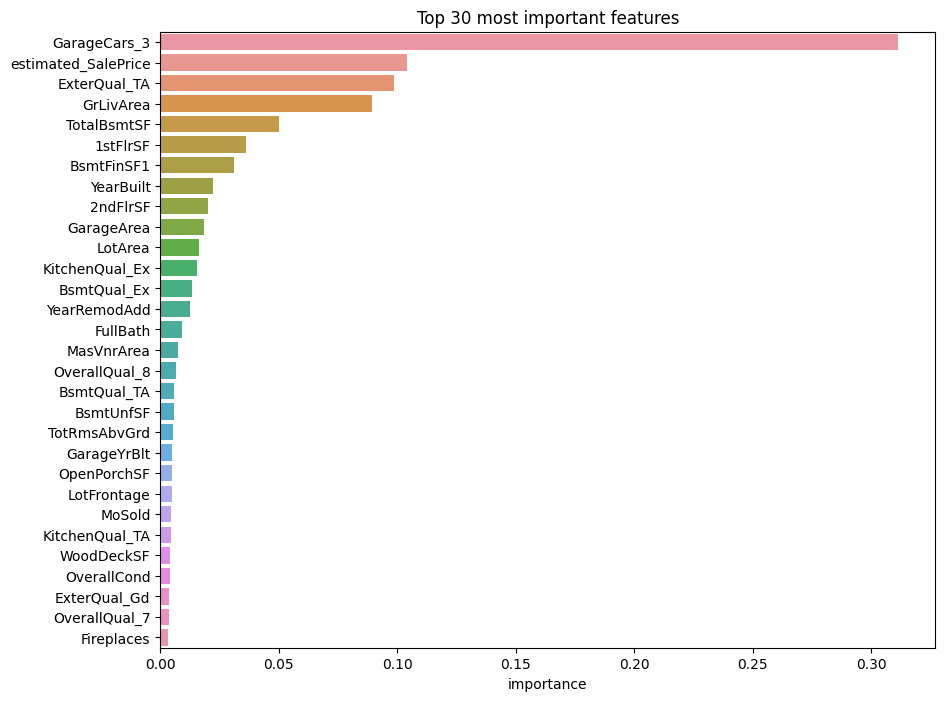

In [20]:
# Rebuild the pipeline
title = "Estimated SalePrice added as a feature"
rf_pipeline_v2 = pipeline_rebuilder(X=X, y=y, numerical_features=numerical_features_2, categorical_features=categorical_features_2 ,title=title)

In [21]:
# Predict SalePrice
# exports to csv, so kept as comment when not needed

# model_prediction(model=rf_pipeline, X_test=df_test, original_data=df_test_orig) 

Score: 0.15696

### Some Preliminary Conclusions
- There are a few features that basically have the same data:
    -   GarageArea and GarageCars - keep GarageArea
    -   OverallQual and OverallCond - We will test with each of them dropped separately
-  There is no sense to have duplicate features after all. We will drop the following features:
    -  All the 'No Garage' features except that of GarageCars
    -  All the 'No Basement' features except that of BsmtQual
- More features that should be categorical:
    - 'MSSubClass'
    - 'MoSold'
    - 'YrSold'
    - 'BsmtFullBath'
    - 'BsmtHalfBath'
    - 'FullBath'
    - 'HalfBath'
    - 'BedroomAbvGr'
    - 'KitchenAbvGr'
    - 'TotRmsAbvGrd'
    - 'Fireplaces'
    - 'MiscVal'
- We will attempt to keep 'OverallQual' as a numerical feature and see how that affects the model.

GarageCars feature removed
Cross-validation scores: [0.87449112 0.83386868 0.85601174 0.8872207  0.80033505], scores average: 0.8503854572413975, std: 0.030813700331088687
Log RMSE Cross-validation scores: [0.13597803 0.16052715 0.15741861 0.146682   0.15686568], scores average: 0.1514942957771813, std: 0.009049358914210492


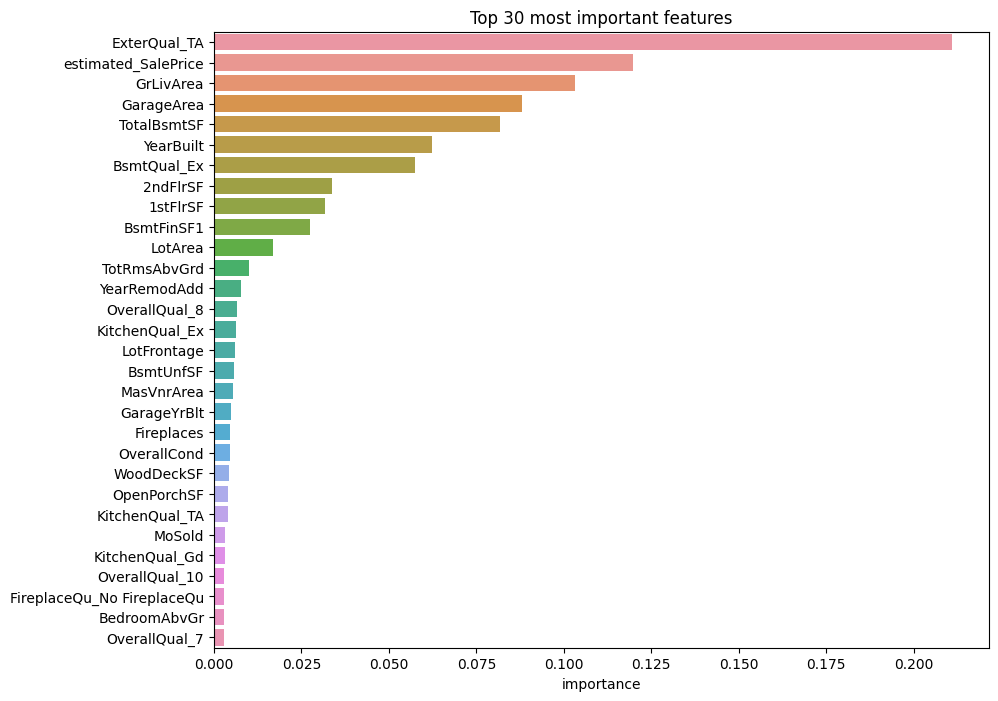

In [22]:
# Remove the 'GarageCars' feature from model prediction
X, df_test, categorical_features_3 = remove_feature(train_data=X, test_data=df_test, feature='GarageCars', feature_index=categorical_features_2)

numerical_features_3 = numerical_features_2
# Rebuild the pipeline
title = "GarageCars feature removed"
rf_pipeline_v3 = pipeline_rebuilder(X=X, y=y, numerical_features=numerical_features_3, categorical_features=categorical_features_3, title=title)

In [23]:
numerical_features

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

OverallCond feature removed, OverallQual as numerical
Cross-validation scores: [0.86560761 0.84995093 0.86518775 0.87935567 0.79981562], scores average: 0.8519835178724804, std: 0.027694128185284456
Log RMSE Cross-validation scores: [0.14392419 0.15528041 0.14836583 0.14230507 0.16024655], scores average: 0.15002440896208288, std: 0.006806899853671051


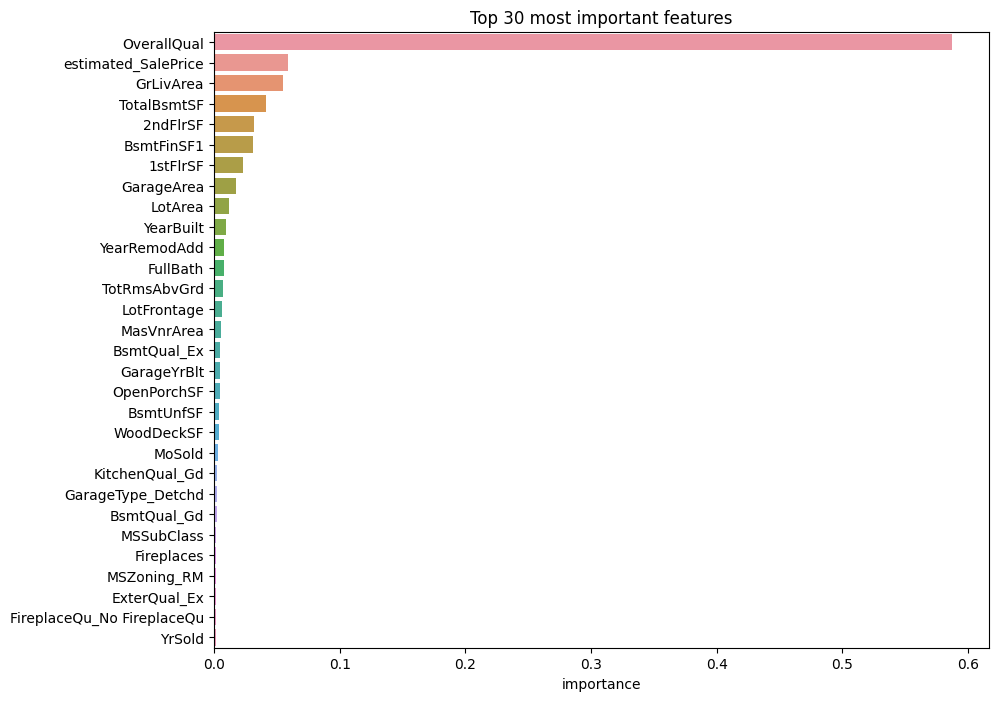

OverallQual feature removed, OverallCond as numerical
Cross-validation scores: [0.87548423 0.82178933 0.85029903 0.88254267 0.8026606 ], scores average: 0.8465551723414609, std: 0.030614005552077765
Log RMSE Cross-validation scores: [0.13642362 0.16322459 0.15684    0.14882101 0.15517177], scores average: 0.15209619857883286, std: 0.00907921054859559


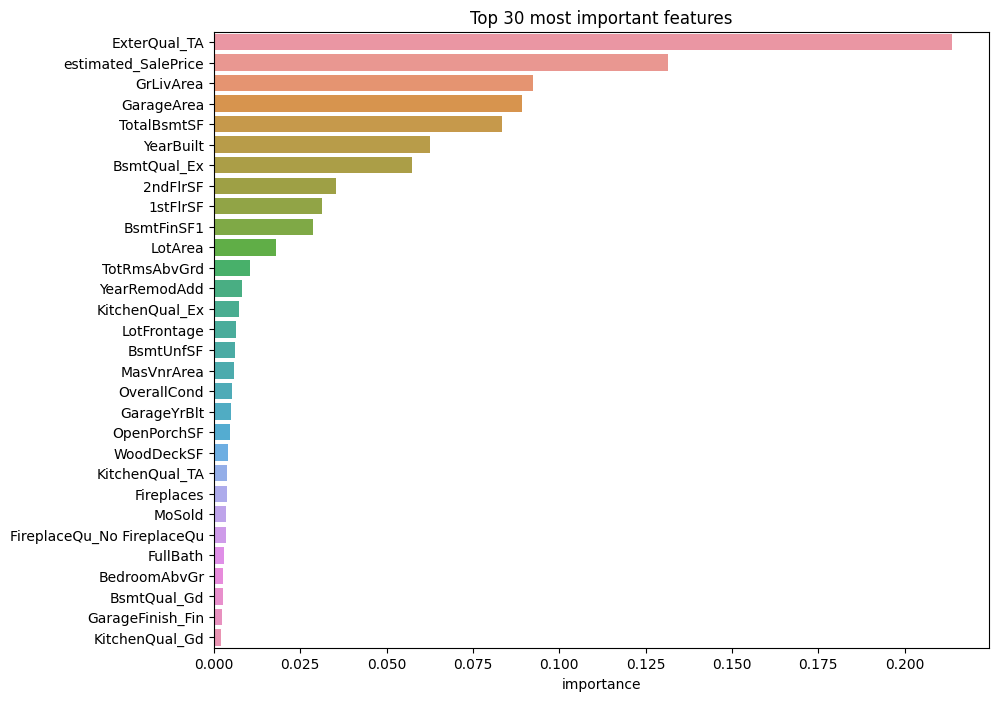

In [25]:
# Convert 'OverallQual' and 'OverallCond' back to numerical features
numerical_features_4, categorical_features_4 = convert_to_numerical(
    df=X,
    columns=['OverallQual'],
    num_features=numerical_features_3,
    cat_features=categorical_features_3
)

# Create versions of X, df_test, and numerical features with 'OverallQual' and 'OverallCond' removed
X_no_overallqual, df_test_no_overallquall, numerical_features_no_overallqual = remove_feature(
    train_data=X, 
    test_data=df_test, 
    feature='OverallQual', 
    feature_index=numerical_features_4
    )

X_no_overallcond, df_test_no_overallcond, numerical_features_no_overallcond = remove_feature(
    train_data=X, 
    test_data=df_test, 
    feature='OverallCond', 
    feature_index=numerical_features_4
    )

# Rebuild the pipeline without 'OverallCond'
title = "OverallCond feature removed, OverallQual as numerical"
rf_pipeline_V4_1 = pipeline_rebuilder(
    X=X_no_overallcond, 
    y=y, 
    numerical_features=numerical_features_no_overallcond, 
    categorical_features=categorical_features_4,
    title=title
    )

# Rebuild the pipeline without 'OverallQual'
title = "OverallQual feature removed, OverallCond as numerical"
rf_pipeline_v4_2 = pipeline_rebuilder(
    X=X_no_overallqual, 
    y=y, 
    numerical_features=numerical_features_no_overallqual, 
    categorical_features=categorical_features_4,
    title=title
    )

OverallCond feature removed, OverallQual as categorical
Cross-validation scores: [0.8696353  0.82662409 0.8554558  0.88385097 0.80551171], scores average: 0.8482155739818754, std: 0.028533907586473395
Log RMSE Cross-validation scores: [0.14093161 0.16456586 0.1580803  0.14975141 0.15840093], scores average: 0.15434602162679484, std: 0.008196206735091196


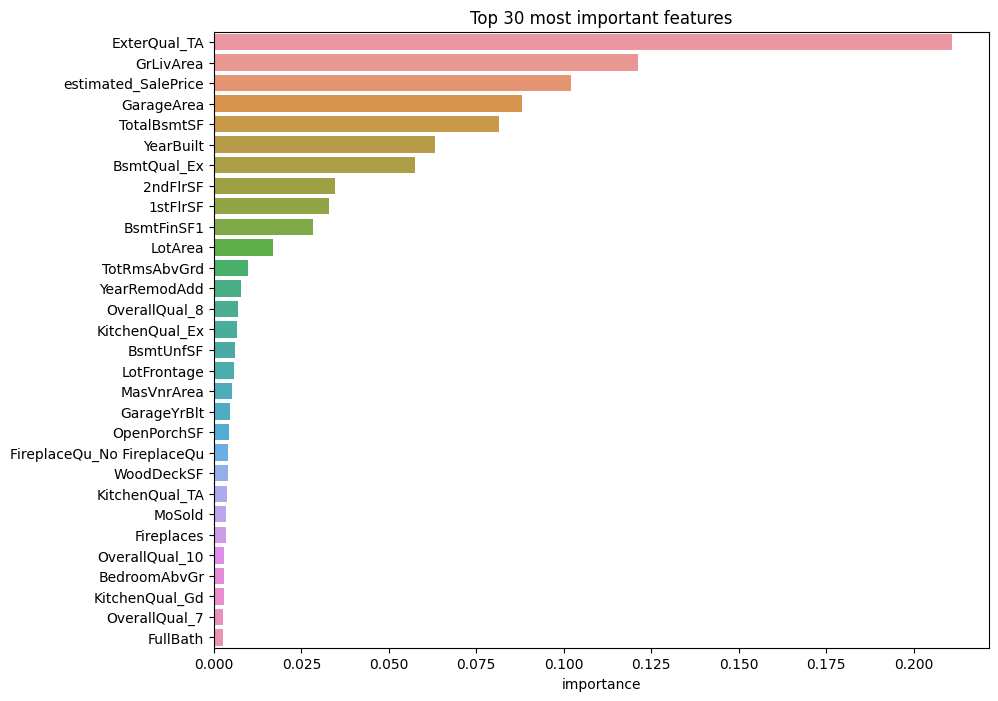

OverallQual feature removed, OverallCond as categorical
Cross-validation scores: [0.87338463 0.82588996 0.84814811 0.88304128 0.79751869], scores average: 0.845596537583204, std: 0.03124300155855663
Log RMSE Cross-validation scores: [0.13989703 0.16445654 0.15865995 0.15030493 0.15906494], scores average: 0.15447667970415316, std: 0.008580432372481238


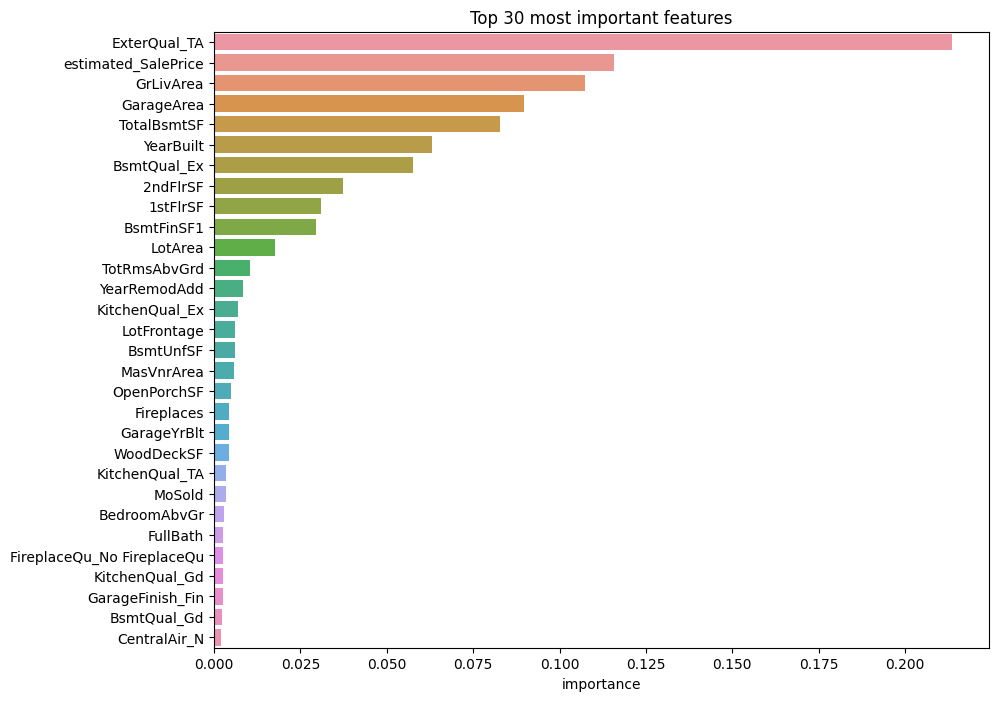

In [26]:
# Convert 'OverallQual' and 'OverallCond' to categorical features again
numerical_features_5, categorical_features_5 = convert_to_categorical(
    df=X,
    columns=['OverallQual', 'OverallCond'],
    num_features=numerical_features_4,
    cat_features=categorical_features_4
)

# Create versions of X, df_test, and categorical features with 'OverallQual' and 'OverallCond' removed
X_no_overallqual, df_test_no_overallquall, categorical_features_no_overallqual = remove_feature(
    train_data=X, 
    test_data=df_test, 
    feature='OverallQual', 
    feature_index=categorical_features_5
    )

X_no_overallcond, df_test_no_overallcond, categorical_features_no_overallcond = remove_feature(
    train_data=X, 
    test_data=df_test, 
    feature='OverallCond', 
    feature_index=categorical_features_5
    )

# Rebuild the pipeline without 'OverallCond'
title = "OverallCond feature removed, OverallQual as categorical"
rf_pipeline_v5_1 = pipeline_rebuilder(
    X=X_no_overallcond, 
    y=y, 
    numerical_features=numerical_features_5, 
    categorical_features=categorical_features_no_overallcond,
    title=title
    )

# Rebuild the pipeline without 'OverallQual'
title = "OverallQual feature removed, OverallCond as categorical"
rf_pipeline_v5_1 = pipeline_rebuilder(
    X=X_no_overallqual, 
    y=y, 
    numerical_features=numerical_features_5, 
    categorical_features=categorical_features_no_overallqual,
    title=title
    )

#### Conclusion of the 'OverallQual' vs 'OverallCond' testing
- The model performs better with 'OverallQual' than with 'OverallCond' as numerical features.
- The model performs better with 'OverallCond' than with 'OverallQual' as categorical features.
- The best model is the one with 'OverallQual' as a numerical feature and without 'OverallCond'.

In [27]:
# Remove 'OverallQual' from the list of suspected categorical features
suspected_categorical.remove('OverallQual')

In [28]:
# Convert suspected categorical features to categorical features
numerical_features_6, categorical_features_6 = convert_to_categorical(
    df=X,
    columns=suspected_categorical,
    num_features=numerical_features_5,
    cat_features=categorical_features_5
)

Suspected categorical features converted to categorical
Cross-validation scores: [0.87405152 0.81852962 0.85077583 0.88417893 0.82623464], scores average: 0.8507541091309774, std: 0.025688950132587738
Log RMSE Cross-validation scores: [0.13943634 0.16394514 0.15889083 0.14772192 0.15398588], scores average: 0.1527960225675407, std: 0.00856846286994431


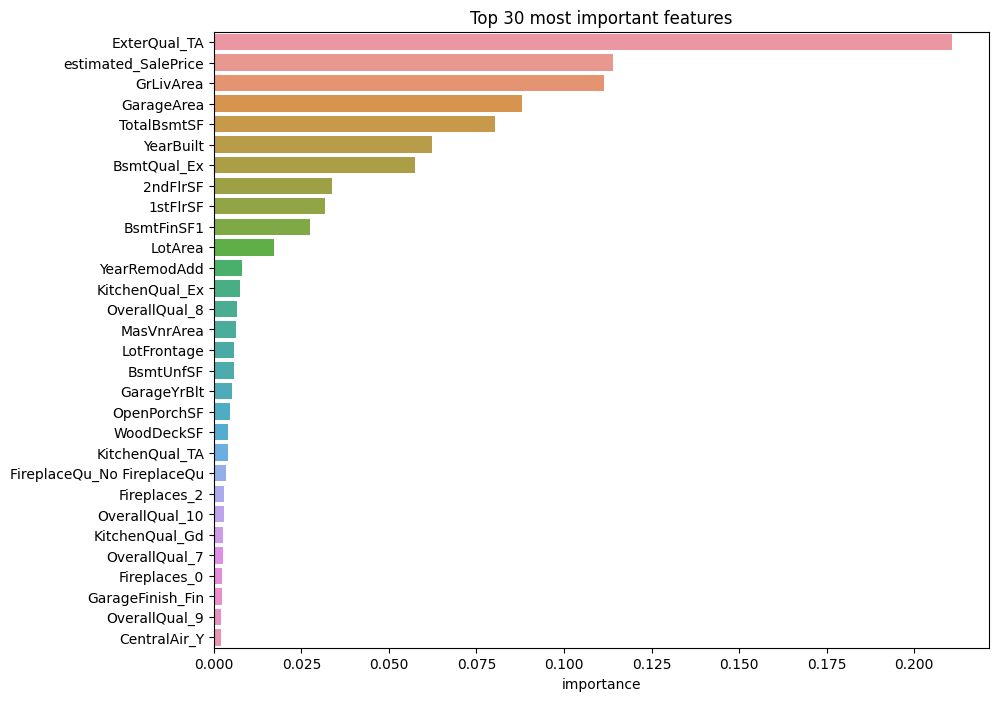

In [29]:
# Rebuild the pipeline
title = "Suspected categorical features converted to categorical"
rf_pipeline_v6 = pipeline_rebuilder(X=X, y=y, numerical_features=numerical_features_6, categorical_features=categorical_features_6, title=title)

The 'ExterQual' and 'ExterCond' features are also very similar. We will test with each of them dropped separately.

ExterQual feature removed
Cross-validation scores: [0.86009463 0.82718409 0.8594277  0.88796131 0.80372952], scores average: 0.8476794478150552, std: 0.029211101313218434
Log RMSE Cross-validation scores: [0.14242841 0.16353148 0.14850117 0.14359262 0.15992273], scores average: 0.15159528177526713, std: 0.00859612577563043


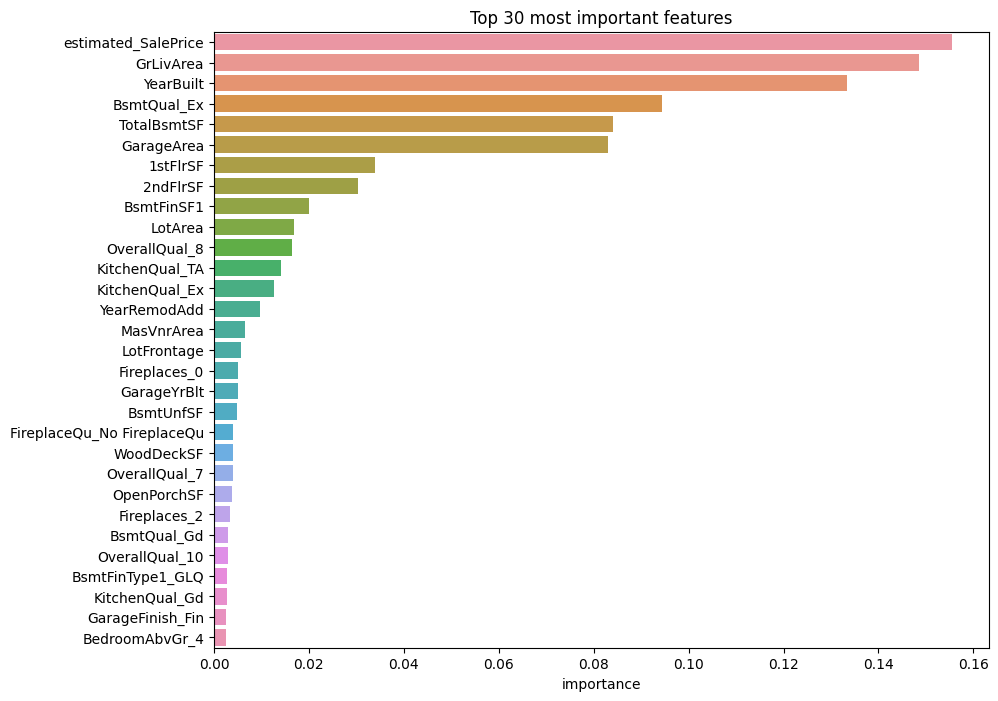

ExterCond feature removed
Cross-validation scores: [0.87366262 0.82424562 0.85500141 0.88133246 0.81702453], scores average: 0.8502533270887506, std: 0.025756573718079094
Log RMSE Cross-validation scores: [0.13934154 0.16443575 0.15834935 0.14846271 0.15580039], scores average: 0.15327794779972886, std: 0.008648563926303091


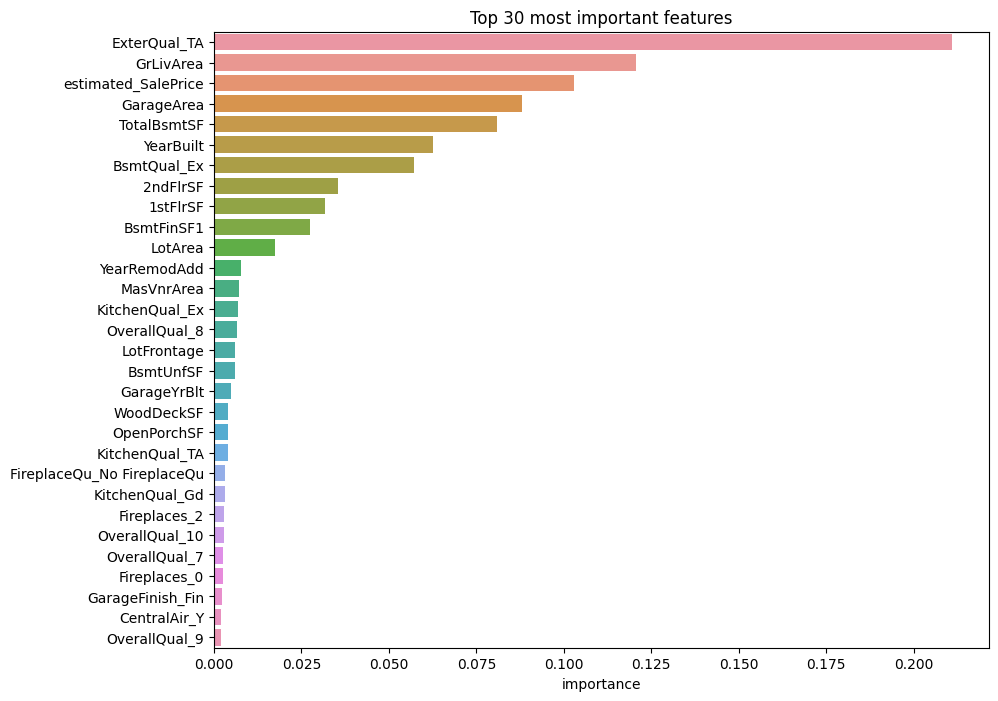

In [31]:
# Create versions of X, df_test, and categorical features with 'ExterQual' and 'ExterCond' removed
X_no_exterqual, df_test_no_exterqual, categorical_features_no_exterqual = remove_feature(
    train_data=X, 
    test_data=df_test, 
    feature='ExterQual', 
    feature_index=categorical_features_6
    )

X_no_extercond, df_test_no_extercond, categorical_features_no_extercond = remove_feature(
    train_data=X, 
    test_data=df_test, 
    feature='ExterCond', 
    feature_index=categorical_features_6
    )

numerical_features_7 = numerical_features_6

# Rebuild the pipeline without 'ExterQual'
title = "ExterQual feature removed"
rf_pipeline_v7_1 = pipeline_rebuilder(
    X=X_no_exterqual, 
    y=y, 
    numerical_features=numerical_features_7, 
    categorical_features=categorical_features_no_exterqual,
    title=title
    )

# Rebuild the pipeline without 'ExterCond'
title = "ExterCond feature removed"
rf_pipeline_v7_2 = pipeline_rebuilder(
    X=X_no_extercond, 
    y=y, 
    numerical_features=numerical_features_7, 
    categorical_features=categorical_features_no_extercond,
    title=title
    )

We will attempt to map the 'ExterQual' and 'ExterCond' features to numerical values and see how that affects the model.

ExterQual and ExterCond converted to numerical
Cross-validation scores: [0.86966768 0.82246061 0.85584855 0.8729147  0.83614966], scores average: 0.8514082379294654, std: 0.019423906583743933
Log RMSE Cross-validation scores: [0.14106212 0.16325395 0.15870052 0.14872852 0.15259356], scores average: 0.15286773404801335, std: 0.007726263283743553


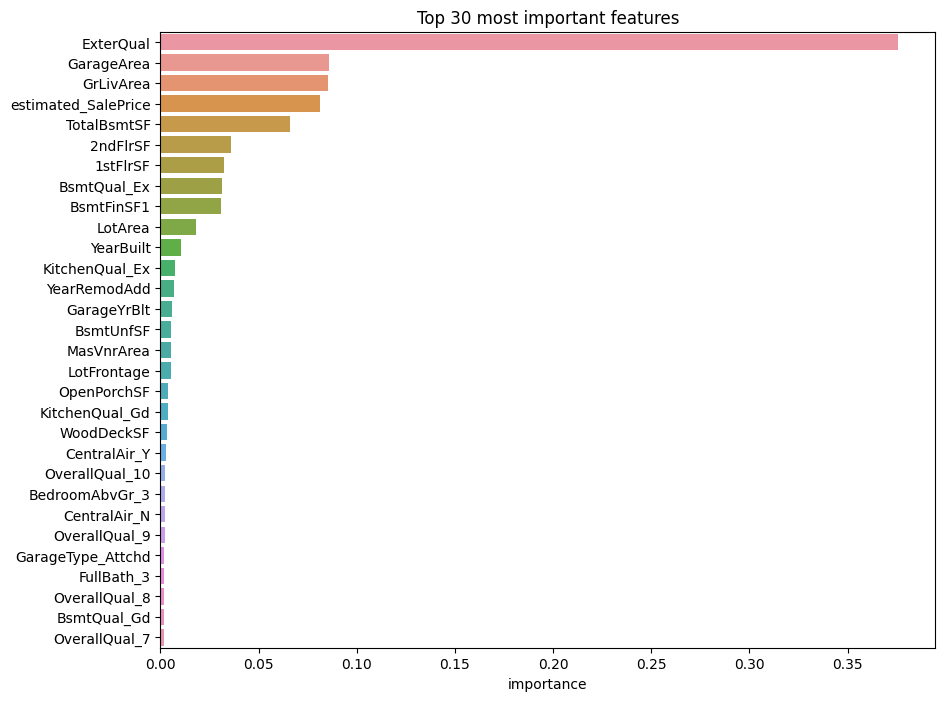

In [32]:
# Map the 'ExterQual' and 'ExterCond' features to numerical values
exter_map = {
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5
}

X['ExterQual'] = X['ExterQual'].map(exter_map)
X['ExterCond'] = X['ExterCond'].map(exter_map)

df_test['ExterQual'] = df_test['ExterQual'].map(exter_map)
df_test['ExterCond'] = df_test['ExterCond'].map(exter_map)

# Convert 'ExterQual' and 'ExterCond' to numerical features
numerical_features_8, categorical_features_8 = convert_to_numerical(
    df=X,
    columns=['ExterQual', 'ExterCond'],
    num_features=numerical_features_7,
    cat_features=categorical_features_6
)

# Rebuild the pipeline
title = "ExterQual and ExterCond converted to numerical"
rf_pipeline_v8 = pipeline_rebuilder(X=X, y=y, numerical_features=numerical_features_8, categorical_features=categorical_features_8, title=title)

In [33]:
print(X['ExterQual'].dtype)
print(X['ExterCond'].dtype)

int64
int64


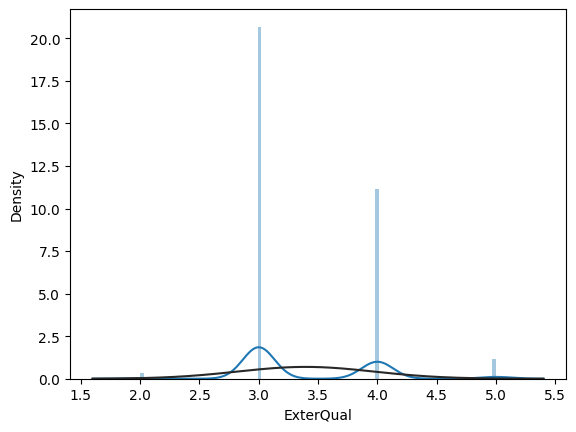

In [34]:
# Display the distribution of the 'ExterQual' feature
sns.distplot(X['ExterQual'], fit=norm, bins=100, kde=True);

In [35]:
# Split the 'ExterQual' feature into 4 quantile bins
X['ExterQual'] = pd.qcut(X['ExterQual'], 4, labels=['poor', 'average', 'good'], duplicates='drop')
df_test['ExterQual'] = pd.qcut(df_test['ExterQual'], 4, labels=['poor', 'average', 'good'], duplicates='drop')

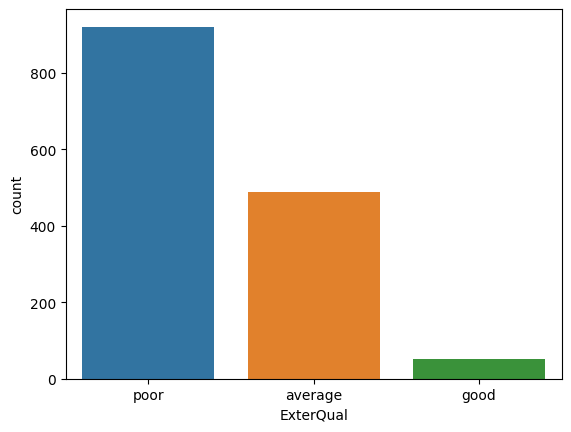

In [36]:
# Display a barplot of the 'ExterQual' feature
sns.countplot(x='ExterQual', data=X);

ExterQual quantile-binned as categorical
Cross-validation scores: [0.86929032 0.82112633 0.86107229 0.87233958 0.83831843], scores average: 0.8524293904055549, std: 0.01966930015324966
Log RMSE Cross-validation scores: [0.1402098  0.16361815 0.15789505 0.14771465 0.15148335], scores average: 0.1521841988348472, std: 0.00808954126648245


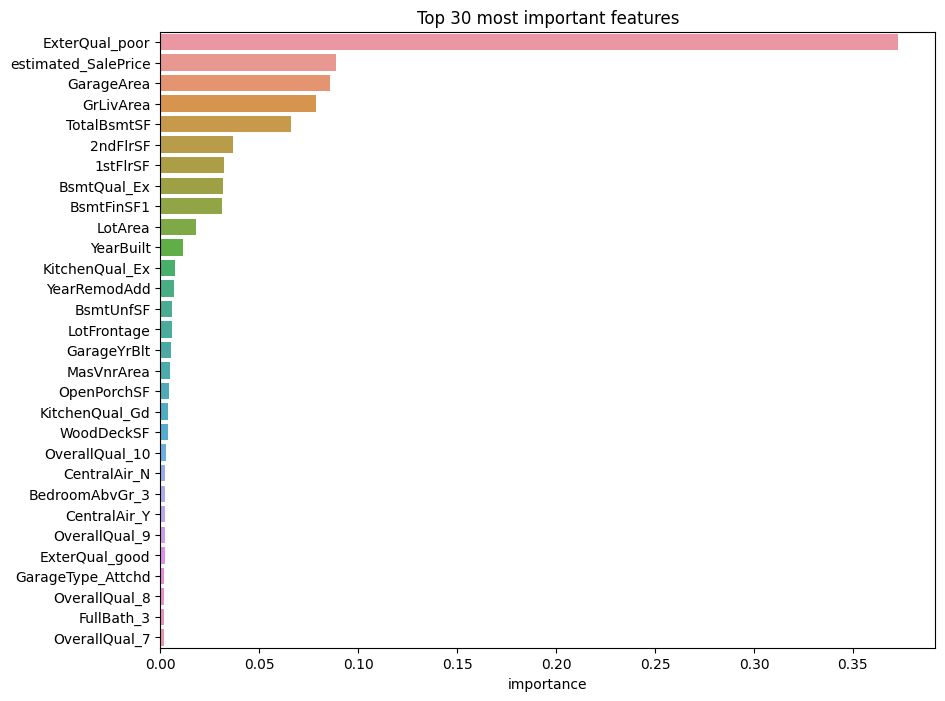

In [37]:
# Convert 'ExterQual' to a categorical feature
numerical_features_9, categorical_features_9 = convert_to_categorical(
    df=X,
    columns=['ExterQual'],
    num_features=numerical_features_8,
    cat_features=categorical_features_8
)

# Rebuild the pipeline
title = "ExterQual quantile-binned as categorical"
rf_pipeline_v9 = pipeline_rebuilder(X=X, y=y, numerical_features=numerical_features_9, categorical_features=categorical_features_9, title=title)

ExterQual feature removed completely
Cross-validation scores: [0.86511992 0.83369375 0.85787033 0.88345118 0.82779833], scores average: 0.8535867028355517, std: 0.020513514655476853
Log RMSE Cross-validation scores: [0.14253322 0.16409051 0.15027752 0.14731454 0.15639863], scores average: 0.15212288446838731, std: 0.0074832227348667025


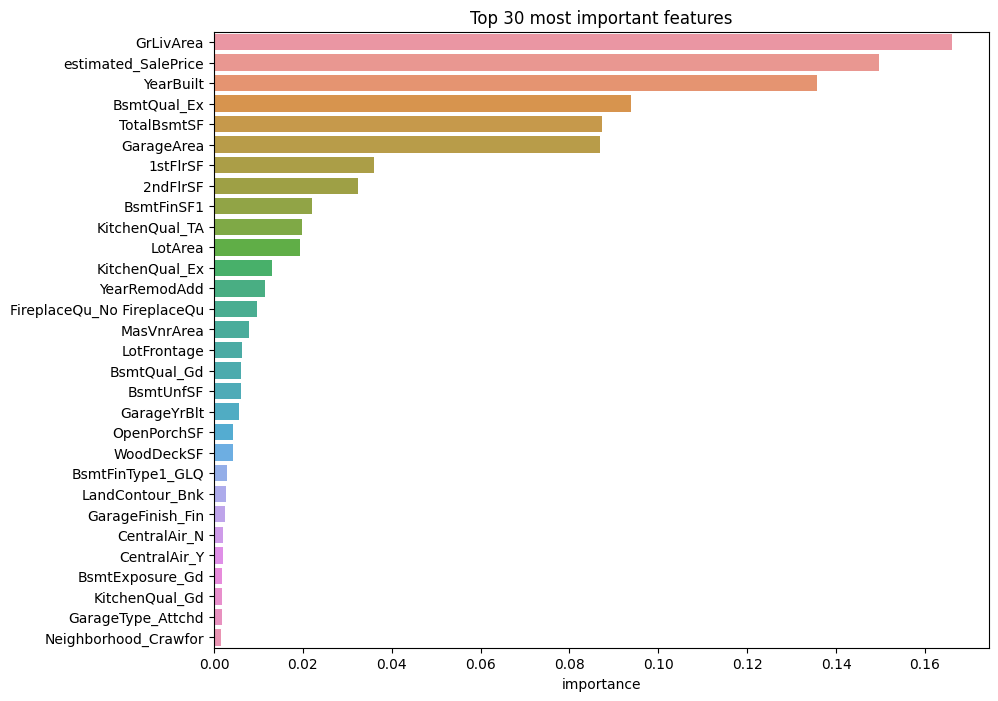

In [38]:
# Dropping 'ExterQual' from the model prediction
X, df_test, categorical_features_10 = remove_feature(train_data=X, test_data=df_test, feature='ExterQual', feature_index=categorical_features)

numerical_features_10 = numerical_features_9

# Rebuild the pipeline
title = "ExterQual feature removed completely"
rf_pipeline_v10 = pipeline_rebuilder(X=X, y=y, numerical_features=numerical_features_10, categorical_features=categorical_features_10, title=title)

In [39]:
base_numerical_features, base_categorical_features = divide_features(df.drop(['SalePrice', 'Id'], axis=1))

In [40]:
X_vars = df.drop(['SalePrice', 'Id'], axis=1)
df_test_vars = df_test_orig.drop('Id', axis=1)

In [41]:
X_vars['ExterQual'].value_counts()

ExterQual
TA    906
Gd    488
Ex     52
Fa     14
Name: count, dtype: int64

In [42]:
X_vars['ExterCond'].value_counts()

ExterCond
TA    1282
Gd     146
Fa      28
Ex       3
Po       1
Name: count, dtype: int64

In [43]:
# Map the 'ExterQual' and 'ExterCond' features to numerical values
exter_map = {
    'Po': 1,
    'Fa': 2,
    'TA': 3,
    'Gd': 4,
    'Ex': 5
}

quality_features = [
    'ExterQual', 
    'ExterCond', 
    'BsmtQual', 
    'BsmtCond', 
    'HeatingQC', 
    'KitchenQual', 
    'FireplaceQu', 
    'GarageQual', 
    'GarageCond', 
    'PoolQC',
    ]

for feature in quality_features:
    X_vars[feature] = X_vars[feature].map(exter_map)
    df_test_vars[feature] = df_test_vars[feature].map(exter_map)

In [44]:
# Convert 'ExterQual' and 'ExterCond' to numerical features
numerical_features, categorical_features = convert_to_numerical(
    df=X_vars,
    columns=[quality_features],
    num_features=base_numerical_features,
    cat_features=base_categorical_features
)

X_vars['estimated_SalePrice'] = X_vars['GrLivArea'] * mean_SalePrice_per_GrLivArea
df_test_vars['estimated_SalePrice'] = df_test_vars['GrLivArea'] * mean_SalePrice_per_GrLivArea
numerical_features = numerical_features.append(pd.Index(['estimated_SalePrice']))

In [45]:
X_vars[numerical_features] = X_vars[numerical_features].fillna(0)
X_vars[numerical_features].isnull().sum()

df_test_vars[numerical_features] = df_test_vars[numerical_features].fillna(0)
df_test_vars[numerical_features].isnull().sum()

MSSubClass             0
LotFrontage            0
LotArea                0
OverallQual            0
OverallCond            0
YearBuilt              0
YearRemodAdd           0
MasVnrArea             0
BsmtFinSF1             0
BsmtFinSF2             0
BsmtUnfSF              0
TotalBsmtSF            0
1stFlrSF               0
2ndFlrSF               0
LowQualFinSF           0
GrLivArea              0
BsmtFullBath           0
BsmtHalfBath           0
FullBath               0
HalfBath               0
BedroomAbvGr           0
KitchenAbvGr           0
TotRmsAbvGrd           0
Fireplaces             0
GarageYrBlt            0
GarageCars             0
GarageArea             0
WoodDeckSF             0
OpenPorchSF            0
EnclosedPorch          0
3SsnPorch              0
ScreenPorch            0
PoolArea               0
MiscVal                0
MoSold                 0
YrSold                 0
estimated_SalePrice    0
dtype: int64

In [46]:
numerical_features, categorical_features = divide_features(X_vars)

In [47]:
X_vars[numerical_features].var(axis=0).sort_values(ascending=False)

estimated_SalePrice   3935508369.205
LotArea                 99625649.650
GrLivArea                 276129.633
MiscVal                   246138.055
BsmtFinSF1                208025.468
GarageYrBlt               205841.236
BsmtUnfSF                 195246.406
TotalBsmtSF               192462.362
2ndFlrSF                  190557.075
1stFlrSF                  149450.079
GarageArea                 45712.510
MasVnrArea                 32663.829
BsmtFinSF2                 26023.908
WoodDeckSF                 15709.813
OpenPorchSF                 4389.861
EnclosedPorch               3735.550
ScreenPorch                 3108.889
LowQualFinSF                2364.204
MSSubClass                  1789.338
PoolArea                    1614.216
LotFrontage                 1201.614
YearBuilt                    912.215
3SsnPorch                    859.506
YearRemodAdd                 426.233
MoSold                         7.310
TotRmsAbvGrd                   2.642
OverallQual                    1.913
Y

In [48]:
scaler = MinMaxScaler()

X_vars_numerical_scaled = scaler.fit_transform(X_vars[numerical_features])

In [49]:
X_vars_numerical_scaled = pd.DataFrame(X_vars_numerical_scaled, columns=numerical_features)

variances = X_vars_numerical_scaled.var(axis=0).sort_values(ascending=False).to_frame()

variances.columns = ['variance']

variances

,variance
PoolQC,0.175
YearRemodAdd,0.118
YrSold,0.110
HalfBath,0.063
MSSubClass,0.062
MoSold,0.060
HeatingQC,0.058
BsmtQual,0.051
GarageYrBlt,0.051
KitchenQual,0.049


In [50]:
high_variance_columns = variances[variances['variance'] >= 0.010].index

low_variance_columns = variances[variances['variance'] < 0.010].index

High variance features selected
Cross-validation scores: [0.85503212 0.82336015 0.84680131 0.85500913 0.77247811], scores average: 0.8305361668239819, std: 0.03125944835898398
Log RMSE Cross-validation scores: [0.14808727 0.16973932 0.16331497 0.14699785 0.16358853], scores average: 0.15834559042105675, std: 0.009121452733574474


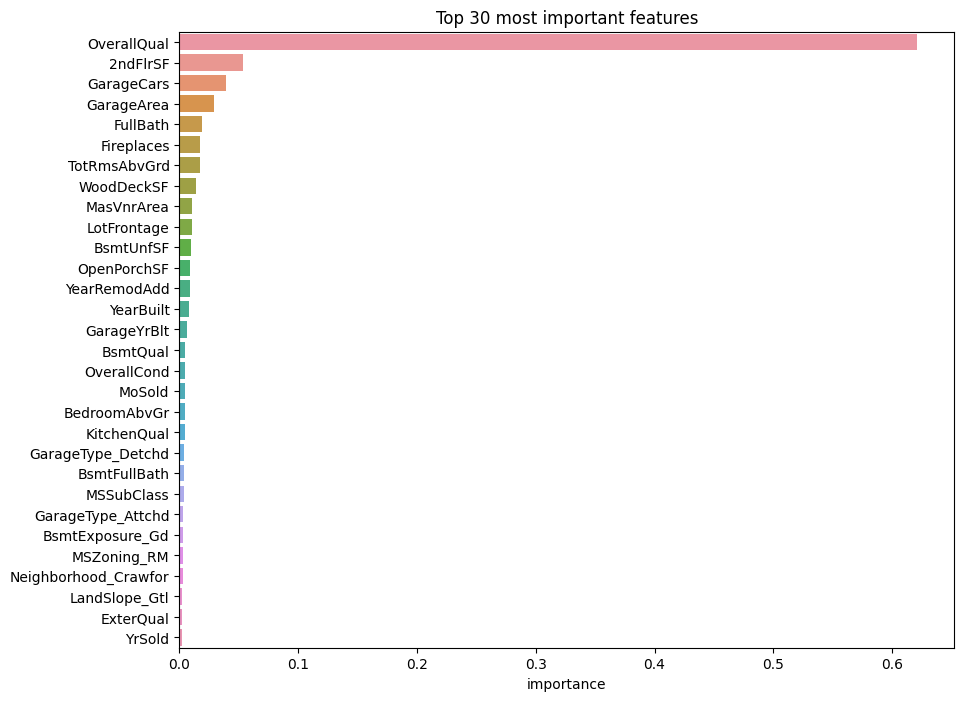

In [51]:
X_high_variance = X_vars[high_variance_columns]

title = "High variance features selected"
rf_pipeline_var = pipeline_rebuilder(
    X=X_vars, 
    y=y, 
    numerical_features=high_variance_columns, 
    categorical_features=categorical_features, 
    title=title
    )

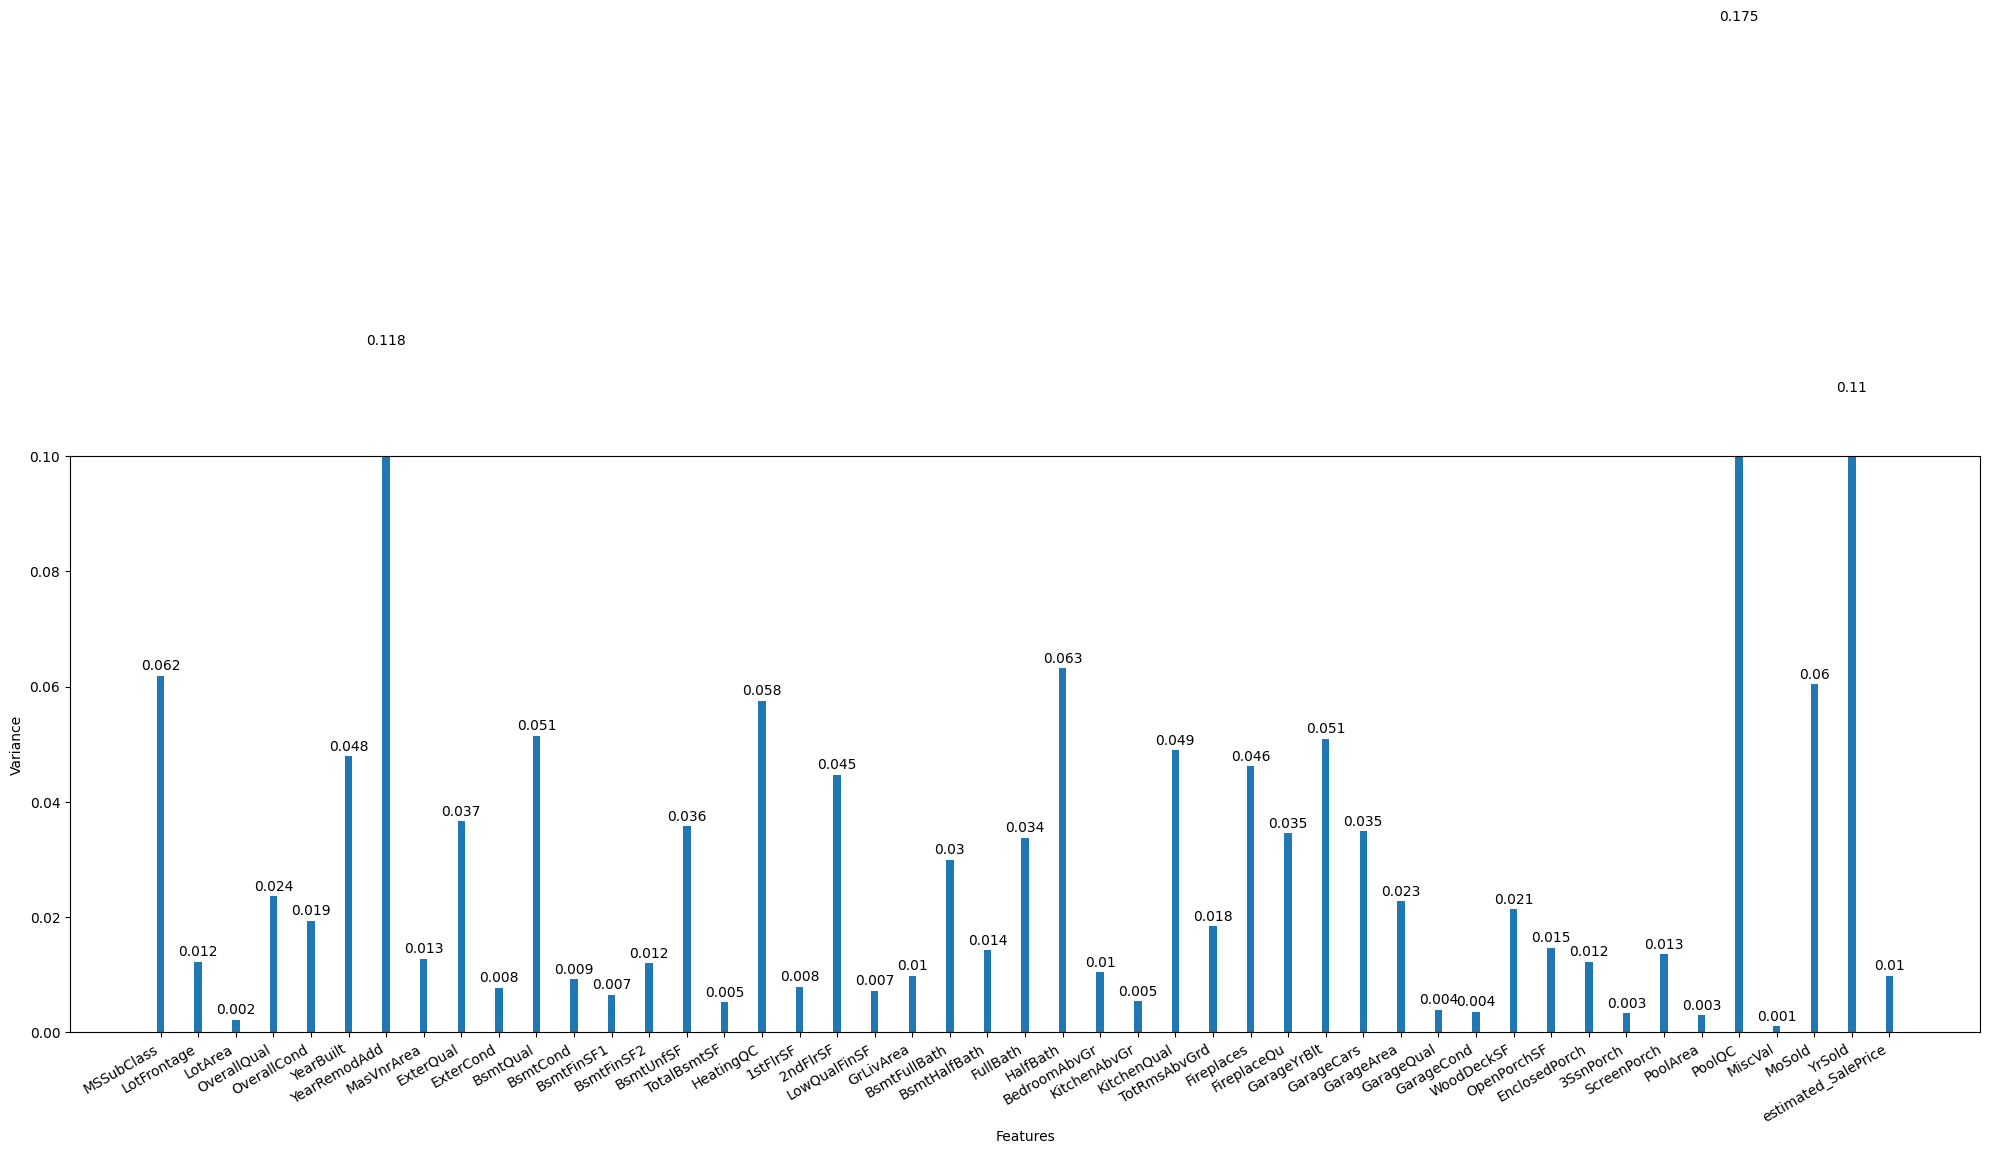

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)

x = X_vars[numerical_features].columns
y = X_vars_numerical_scaled.var(axis=0)

ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')
    
fig.autofmt_xdate()
plt.tight_layout()

In [54]:
X['ExterQual'] = df['ExterQual']

X_selection = extract_processed_df(
    pipeline=rf_pipeline_v6, 
    X=X,
    numerical_features=numerical_features_6, 
    categorical_features=categorical_features_6
    )

y = df['SalePrice']

rf_model_v6 = rf_pipeline_v6.named_steps['model']

In [55]:
boruta_selector = BorutaPy(rf_model_v6, random_state=42, max_iter=100)

boruta_selector.fit(X_selection.values, y.values.ravel())

X_selected = boruta_selector.transform(X_selection.values)

In [56]:
selected_features_mask = boruta_selector.support_

selected_features = X_selection.columns[selected_features_mask]

selected_features

Index(['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea',
       'estimated_SalePrice', 'ExterQual_TA', 'BsmtQual_Ex', 'KitchenQual_Ex',
       'OverallQual_8'],
      dtype='object')

In [57]:
weak_features_mask = boruta_selector.support_weak_

weak_features = X_selection.columns[weak_features_mask]

weak_features

Index(['BsmtUnfSF', 'GarageYrBlt'], dtype='object')

In [58]:
X_selected = pd.DataFrame(X_selected, columns=selected_features)

X_selected.head()

,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,GarageArea,estimated_SalePrice,ExterQual_TA,BsmtQual_Ex,KitchenQual_Ex,OverallQual_8
0,8450.000,2003.000,2003.000,196.000,706.000,856.000,856.000,854.000,1710.000,548.000,204145.599,0.000,0.000,0.000,0.000
1,9600.000,1976.000,1976.000,0.000,978.000,1262.000,1262.000,0.000,1262.000,460.000,150661.840,1.000,0.000,0.000,0.000
2,11250.000,2001.000,2002.000,162.000,486.000,920.000,920.000,866.000,1786.000,608.000,213218.737,0.000,0.000,0.000,0.000
3,9550.000,1915.000,1970.000,0.000,216.000,756.000,961.000,756.000,1717.000,642.000,204981.283,1.000,0.000,0.000,0.000
4,14260.000,2000.000,2000.000,350.000,655.000,1145.000,1145.000,1053.000,2198.000,836.000,262404.694,0.000,0.000,0.000,1.000


In [59]:
# RE-split numerical and categorical features
numerical_features, categorical_features = divide_features(X_selected)

# build rf model
rf_model_11 = RandomForestRegressor(random_state=42, n_jobs=-1)

rf_model_11.fit(X_selected, y)

current_scores = cross_validate_estimator(estimator=rf_model_11, X=X_selected, y=y, cv=5)

scores['Boruta RF model'] = current_scores

Cross-validation scores: [0.86570561 0.8118698  0.862489   0.87099642 0.82239721], scores average: 0.8466916057025683, std: 0.02451362728396932
Log RMSE Cross-validation scores: [0.15262262 0.17356838 0.1587881  0.15790097 0.17025199], scores average: 0.16262641181777363, std: 0.007937435590977957


### Scores for the different pipelines:

In [60]:
# Convert scores to a DataFrame
scores_df = pd.DataFrame(scores)
scores_df = scores_df.transpose()

# Rename columns
scores_df.columns = ['Average CV Score', 'CV Score Std', 'Average RMSE', 'RMSE Std']

# Sort the DataFrame by average MSE and MSE Std
scores_df[['Average RMSE', 'RMSE Std']].sort_values(by=['Average RMSE', 'RMSE Std'], ascending=True)

,Average RMSE,RMSE Std
Base RF model,0.147,0.007
Estimated SalePrice added as a feature,0.150,0.010
OverallQual and GarageCars converted to categorical,0.150,0.010
"OverallCond feature removed, OverallQual as numerical",0.150,0.007
GarageCars feature removed,0.151,0.009
ExterQual feature removed,0.152,0.009
"OverallQual feature removed, OverallCond as numerical",0.152,0.009
ExterQual feature removed completely,0.152,0.007
ExterQual quantile-binned as categorical,0.152,0.008
Suspected categorical features converted to categorical,0.153,0.009


In [61]:
# Sort the DataFrame by average cv score and cv score std
scores_df[['Average CV Score', 'CV Score Std']].sort_values(by=['Average CV Score', 'CV Score Std'], ascending=[False, True])

,Average CV Score,CV Score Std
Base RF model,0.857,0.026
Estimated SalePrice added as a feature,0.854,0.038
OverallQual and GarageCars converted to categorical,0.854,0.035
ExterQual feature removed completely,0.854,0.021
ExterQual quantile-binned as categorical,0.852,0.020
"OverallCond feature removed, OverallQual as numerical",0.852,0.028
ExterQual and ExterCond converted to numerical,0.851,0.019
Suspected categorical features converted to categorical,0.851,0.026
GarageCars feature removed,0.850,0.031
ExterCond feature removed,0.850,0.026


## Part 4: Advanced Methods and Model Enhancement
- Custom Feature Engineering:
    - Calculate mean price per area for each quality group.
    - Use these values to create estimations based on apartment quality group and living area.
    - Explore and create additional custom features to enhance model performance.
    - Document the impact of these features on the model's accuracy.
- Kaggle Competition and Stacked Regression:
    - Integrate new features into the stacked regression notebook provided (link: Stacked Regressions Notebook).
    - Submit the updated model to Kaggle and report the new score.
